In [1]:
%matplotlib inline
import os
from glob import glob
from astropy.io import fits

import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family='serif', size=16)

In [2]:
dr12dir = 'sdss_dr12/'

### Calculate line ratios

In [4]:
grauer_snia = np.genfromtxt('typeIa_spectra/grauer_SNIa.txt', dtype=int)

emlinesfits = fits.open(dr12dir + 'portsmouth_emlinekin_full-DR12-all.fits')

emlinesfits[1].header


XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                 2212 /Number of bytes per row                         
NAXIS2  =              2440798 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   49 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** End of mandator

## Get emission line fluxes for SN Ia

In [6]:
snia_list = []
snia_idxs = []
OIIItoHb_ratio = []
NIItoHa_ratio  = []
SIItoHa_ratio  = []
OItoHa_ratio   = []

for snia in grauer_snia:
    plate, mjd, fiber = snia
    
    stringid = '%s-%s-%s' % (plate, mjd, fiber)

    try:
        snia_idx = np.where((emlinesfits[1].data['PLATE'] == plate)
                            & (emlinesfits[1].data['MJD'] == mjd)
                            & (emlinesfits[1].data['FIBERID'] == fiber))[0][0]
        snia_idxs.append(snia_idx)
    except IndexError:
        print "Bad: ", plate, mjd, fiber
        continue
        
#     print emlinesfits[1].data[snia_idx]
    
#     lines are Ha, Hb, [OIII] (5007), [NII] (6583), [SII] (6716), [OI] (6300)
    Ha_line   = emlinesfits[1].data[snia_idx]['LAMBDA'][-4]
    Hb_line   = emlinesfits[1].data[snia_idx]['LAMBDA'][15]
    OIII_line = emlinesfits[1].data[snia_idx]['LAMBDA'][17]
    NII_line  = emlinesfits[1].data[snia_idx]['LAMBDA'][-3]
    SII_line  = emlinesfits[1].data[snia_idx]['LAMBDA'][-2]
    OI_line   = emlinesfits[1].data[snia_idx]['LAMBDA'][-7]
    
    Ha_line_FLUX   = emlinesfits[1].data[snia_idx]['FLUX'][-4]
    Hb_line_FLUX   = emlinesfits[1].data[snia_idx]['FLUX'][15]
    OIII_line_FLUX = emlinesfits[1].data[snia_idx]['FLUX'][17]
    NII_line_FLUX  = emlinesfits[1].data[snia_idx]['FLUX'][-3]
    SII_line_FLUX  = emlinesfits[1].data[snia_idx]['FLUX'][-2]
    OI_line_FLUX   = emlinesfits[1].data[snia_idx]['FLUX'][-7]
    
#     print Ha_line, Hb_line, OIII_line, NII_line
#     print Ha_line_FLUX, Hb_line_FLUX, OIII_line_FLUX, NII_line_FLUX
    
    if not (Ha_line_FLUX*Hb_line_FLUX*OIII_line_FLUX*NII_line_FLUX*SII_line_FLUX*OI_line_FLUX == 0):
        snia_list.append(stringid)
        OIIItoHb_ratio.append(OIII_line_FLUX / Hb_line_FLUX)
        NIItoHa_ratio.append(NII_line_FLUX / Ha_line_FLUX)
        SIItoHa_ratio.append(SII_line_FLUX / Ha_line_FLUX)
        OItoHa_ratio.append(OI_line_FLUX / Ha_line_FLUX)
        
        print plate, mjd, fiber
    else:
        print "Zero flux:", plate, mjd, fiber

Zero flux: 271 51883 171
Zero flux: 291 51928 76
313 51673 154
328 52282 570
358 51818 181
Zero flux: 394 51812 554
418 51884 144
Bad:  424 51893 355
Zero flux: 438 51884 166
438 51884 462
452 51911 319
Zero flux: 480 51989 24
Zero flux: 498 51984 102
Bad:  500 51994 100
Zero flux: 578 52339 314
604 52079 209
606 52365 412
622 52054 11
Zero flux: 738 52521 360
745 52258 92
Zero flux: 762 52232 67
814 52443 249
844 52378 462
905 52643 213
Zero flux: 915 52443 543
966 52642 221
1038 52673 135
Zero flux: 1059 52618 144
1171 52753 185
1189 52668 239
1205 52670 632
Zero flux: 1278 52735 425
Zero flux: 1289 52734 413
1298 52964 304
1310 53033 459
1324 53088 169
Zero flux: 1337 52767 480
Bad:  1392 52822 147
1400 53470 234
1400 53470 351
Zero flux: 1403 53227 456
1445 53062 67
Bad:  1462 53112 638
Zero flux: 1581 53149 470
1598 53033 380
1645 53172 349
Zero flux: 1697 53142 506
1700 53502 302
Zero flux: 1710 53504 488
Bad:  1744 53055 210
Zero flux: 1755 53386 309
1758 53084 523
1782 53383 51

## Get emission line fluxes for random galaxy types

In [8]:
gal_list = []
gal_OIIItoHb_ratio = []
gal_NIItoHa_ratio  = []
gal_SIItoHa_ratio  = []
gal_OItoHa_ratio   = []

tot_num_gals = emlinesfits[1].header['NAXIS2']
print tot_num_gals

BPT_types = ['Composite', 'LINER', 'Seyfert',
           'Seyfert/LINER', 'Star Fo', 'Star Forming']

gal_idxs = range(tot_num_gals)

# how many galaxies to plot, roughtly 30% will be usable
Ngals = 100000

randgals = random.sample(gal_idxs, Ngals)

clean_gal_idxs = [gal for gal in randgals if gal not in snia_idxs]

for gal_idx in clean_gal_idxs:#[:1]:
            
    if not emlinesfits[1].data[gal_idx]['BPT'] in BPT_types:
#         print "Bad BPT Type: ", emlinesfits[1].data[gal_idx]['BPT']
        continue
        
    plate = emlinesfits[1].data[gal_idx]['PLATE']
    mjd   = emlinesfits[1].data[gal_idx]['MJD']
    fiber = emlinesfits[1].data[gal_idx]['FIBERID']
    
    stringid = "%d-%d-%d" % (plate, mjd, fiber)
        
#     print emlinesfits[1].data[gal_idx]
    
#     lines are Ha, Hb, [OIII] (5007), [NII] (6583), [SII] (6716), [OI] (6300)
    Ha_line   = emlinesfits[1].data[gal_idx]['LAMBDA'][-4]
    Hb_line   = emlinesfits[1].data[gal_idx]['LAMBDA'][15]
    OIII_line = emlinesfits[1].data[gal_idx]['LAMBDA'][17]
    NII_line  = emlinesfits[1].data[gal_idx]['LAMBDA'][-3]
    SII_line  = emlinesfits[1].data[gal_idx]['LAMBDA'][-2]
    OI_line   = emlinesfits[1].data[gal_idx]['LAMBDA'][-7]
    
    Ha_line_FLUX   = emlinesfits[1].data[gal_idx]['FLUX'][-4]
    Hb_line_FLUX   = emlinesfits[1].data[gal_idx]['FLUX'][15]
    OIII_line_FLUX = emlinesfits[1].data[gal_idx]['FLUX'][17]
    NII_line_FLUX  = emlinesfits[1].data[gal_idx]['FLUX'][-3]
    SII_line_FLUX  = emlinesfits[1].data[gal_idx]['FLUX'][-2]
    OI_line_FLUX   = emlinesfits[1].data[gal_idx]['FLUX'][-7]
    
#     print Ha_line, Hb_line, OIII_line, NII_line
#     print Ha_line_FLUX, Hb_line_FLUX, OIII_line_FLUX, NII_line_FLUX
    
    if not (Ha_line_FLUX*Hb_line_FLUX*OIII_line_FLUX*NII_line_FLUX*SII_line_FLUX*OI_line_FLUX == 0):
        gal_list.append(stringid)
        gal_OIIItoHb_ratio.append(OIII_line_FLUX / Hb_line_FLUX)
        gal_NIItoHa_ratio.append(NII_line_FLUX / Ha_line_FLUX)
        gal_SIItoHa_ratio.append(SII_line_FLUX / Ha_line_FLUX)
        gal_OItoHa_ratio.append(OI_line_FLUX / Ha_line_FLUX)

#         print plate, mjd, fiber
#     else:
#         print "Zero flux:", plate, mjd, fiber

print len(gal_list)

2440798


/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in float_scalars
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in float_scalars
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in float_scalars
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in float_scalars
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in float_scalars
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in float_scalars
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:59: Runtime

31256


/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


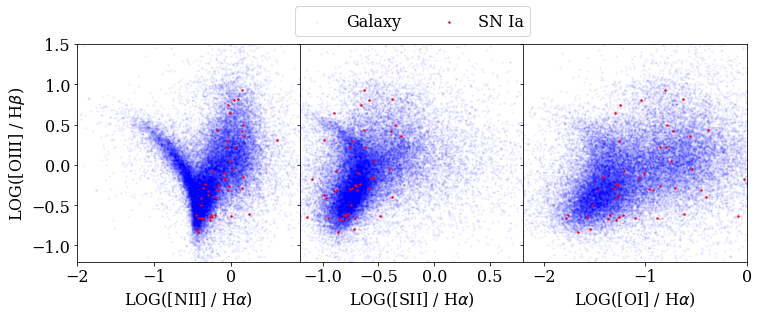

In [11]:
logOIIItoHb_ratio = [np.log10(OIIItoHb) for OIIItoHb in OIIItoHb_ratio]
logNIItoHa_ratio  = [np.log10(NIItoHa)  for NIItoHa  in NIItoHa_ratio]
logSIItoHa_ratio  = [np.log10(SIItoHa)  for SIItoHa  in SIItoHa_ratio]
logOItoHa_ratio   = [np.log10(OItoHa)   for OItoHa   in OItoHa_ratio]

gal_logOIIItoHb_ratio = [np.log10(gal_OIIItoHb) for gal_OIIItoHb in gal_OIIItoHb_ratio]
gal_logNIItoHa_ratio  = [np.log10(gal_NIItoHa)  for gal_NIItoHa  in gal_NIItoHa_ratio]
gal_logSIItoHa_ratio  = [np.log10(gal_SIItoHa)  for gal_SIItoHa  in gal_SIItoHa_ratio]
gal_logOItoHa_ratio   = [np.log10(gal_OItoHa)   for gal_OItoHa   in gal_OItoHa_ratio]


fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].scatter(gal_logNIItoHa_ratio, gal_logOIIItoHb_ratio, color='b', alpha=0.05, s=2, label='Galaxy')
ax[1].scatter(gal_logSIItoHa_ratio, gal_logOIIItoHb_ratio, color='b', alpha=0.05, s=2, label='Galaxy')
ax[2].scatter(gal_logOItoHa_ratio,  gal_logOIIItoHb_ratio, color='b', alpha=0.05, s=2, label='Galaxy')

ax[0].scatter(logNIItoHa_ratio, logOIIItoHb_ratio, color='r', s=2, label='SN Ia')
ax[1].scatter(logSIItoHa_ratio, logOIIItoHb_ratio, color='r', s=2, label='SN Ia')
ax[2].scatter(logOItoHa_ratio,  logOIIItoHb_ratio, color='r', s=2, label='SN Ia')


ax[0].set(xlabel=r'LOG([NII] / H$\alpha$)',
          ylabel=r'LOG([OIII] / H$\beta$)',
          xlim=[-2, 0.9],
          ylim=[-1.2, 1.5])
ax[1].set(xlabel=r'LOG([SII] / H$\alpha$)',
          xlim=[-1.2, 0.8]
         )
ax[2].set(xlabel=r'LOG([OI] / H$\alpha$)',
         xlim=[-2.2, 0]
         )

ax[0].legend(bbox_to_anchor=(0.94, 1), ncol=2)
